In [1]:
!pip install -U transformers accelerate


In [2]:
# Colab cell 1 (updated install)
!pip install -U transformers datasets evaluate accelerate gradio


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 503.6/503.6 kB 19.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.5/63.5 MB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 325.4/325.4 kB 23.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 15.6 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 18.1.0
    Uninstalling pyarrow-18.1.0:
      Successfully uninstalled pyarrow-18.1.0
  Attempting uninstall: gradio-client
    Found existing installation: gradio_client 1.13.0
    Uninstalling gradio_client-1.13.0:
      Successfully uninstalled gradio_client-1.13.0
  Attempting uninstall: gradio
    Found existing installation: gradio 5.46.0
    Uninstalling gradio-5.46.0:
      Successfully uninstalled gradio-5.46.0
  Attempting uninstall: datasets
    Found existing installation: datasets 4.0.0
    Uninstalling datasets-4.0.0:
      Successfully uninstalled datasets-4.0.0
ERROR: pip's dependency

In [3]:
# Colab cell 2
import os
import numpy as np
import torch
print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("Device:", "cuda" if torch.cuda.is_available() else "cpu")


PyTorch version: 2.8.0+cu126
CUDA available: True
Device: cuda


In [4]:
# Colab cell 3
from datasets import load_dataset

raw_datasets = load_dataset("ag_news")
print(raw_datasets)
# sample
print(raw_datasets["train"][0])


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 120000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 7600
    })
})
{'text': "Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again.", 'label': 2}


In [5]:
# Colab cell 4 - Choose run mode
# Set RUN_MODE to "fast" (small subset) for quick experiment (~20 mins) or "full" to train on full dataset (slower).
RUN_MODE = "fast"   # options: "fast" or "full"

if RUN_MODE == "fast":
    # use small subsets for fast iteration
    train_size = 20000    # 20k (quick)
    test_size  = 4000
    print("Fast mode: using subsets (train 20k, test 4k)")
else:
    train_size = None
    test_size  = None
    print("Full mode: using entire dataset (slower)")

# Create subsets if fast
if RUN_MODE == "fast":
    train_dataset = raw_datasets["train"].shuffle(seed=42).select(range(train_size))
    test_dataset  = raw_datasets["test"].shuffle(seed=42).select(range(test_size))
else:
    train_dataset = raw_datasets["train"]
    test_dataset  = raw_datasets["test"]

print("Train size:", len(train_dataset), "Test size:", len(test_dataset))


Fast mode: using subsets (train 20k, test 4k)
Train size: 20000 Test size: 4000


In [6]:
# Colab cell 5
from transformers import AutoTokenizer

model_checkpoint = "bert-base-uncased"   # as requested
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

# AG News usually has 'text' field; fallback to combining title+description if needed
def preprocess_function(examples):
    if "text" in examples:
        texts = examples["text"]
    else:
        # fallback if dataset has title/description
        texts = [ (t + " " + d).strip() for t,d in zip(examples.get("title",[""]*len(examples)), examples.get("description",[""]*len(examples))) ]
    return tokenizer(texts, truncation=True, padding=False)

# Apply tokenization (batched)
tokenized_train = train_dataset.map(preprocess_function, batched=True)
tokenized_test  = test_dataset.map(preprocess_function, batched=True)

print(tokenized_train.column_names)


Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask']


In [7]:
# Colab cell 6
import torch
from transformers import DataCollatorWithPadding, AutoModelForSequenceClassification

num_labels = len(set(train_dataset["label"]))  # should be 4 for AG News
print("num_labels:", num_labels)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=num_labels)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


num_labels: 4


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [13]:
from transformers import TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, f1_score
import numpy as np

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1_macro": f1_score(labels, preds, average="macro")
    }

training_args = TrainingArguments(
    output_dir="./bert-ag-news-results",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=1,   # set to 1 for quick run
    weight_decay=0.01,
    logging_steps=100,
    do_eval=True,
    fp16=True if torch.cuda.is_available() else False,
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

train_result = trainer.train()
trainer.save_model("bert-ag-news-model")


/tmp/ipython-input-3527743298.py:26: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
100,0.729000
200,0.352200
300,0.373300
400,0.303400
500,0.298100
600,0.266300
700,0.241500
800,0.215300
900,0.246100
1000,0.258300


Eval results: {'eval_loss': 0.22965119779109955, 'eval_accuracy': 0.9275, 'eval_f1_macro': 0.9270522357900317, 'eval_runtime': 5.8996, 'eval_samples_per_second': 678.014, 'eval_steps_per_second': 21.188, 'epoch': 1.0}
              precision    recall  f1-score   support

           0     0.9628    0.9087    0.9350       997
           1     0.9722    0.9922    0.9821      1024
           2     0.8922    0.8869    0.8896       999
           3     0.8834    0.9204    0.9015       980

    accuracy                         0.9275      4000
   macro avg     0.9277    0.9271    0.9271      4000
weighted avg     0.9282    0.9275    0.9275      4000



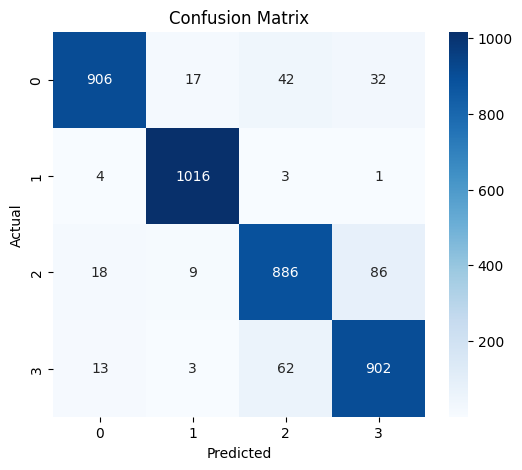

In [14]:
# Colab cell 9
eval_results = trainer.evaluate(tokenized_test)
print("Eval results:", eval_results)

# Confusion matrix and classification report
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare full preds on test set
preds_output = trainer.predict(tokenized_test)
preds = np.argmax(preds_output.predictions, axis=-1)
labels = preds_output.label_ids

print(classification_report(labels, preds, digits=4))

cm = confusion_matrix(labels, preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [15]:
# Colab cell 10
# label mapping for AG News (common mapping)
label_mapping = {0: "World", 1: "Sports", 2: "Business", 3: "Sci/Tech"}

def predict_text(text):
    enc = tokenizer(text, truncation=True, return_tensors="pt").to(device)
    model.eval()
    with torch.no_grad():
        outputs = model(**enc)
        pred = int(outputs.logits.argmax(dim=-1).cpu().numpy()[0])
    return {"label": label_mapping[pred], "label_id": pred}

# quick test
print(predict_text("Apple releases new iPhone with better battery life"))
print(predict_text("Manchester United win the match 3-1"))

# Gradio demo (optional; will open a shareable link in Colab)
import gradio as gr
iface = gr.Interface(fn=lambda t: predict_text(t)["label"], inputs="text", outputs="text", title="AG News BERT Classifier")
iface.launch(share=True)


{'label': 'Sci/Tech', 'label_id': 3}
{'label': 'Sports', 'label_id': 1}
Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://e6d6e90922f04e325b.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
